In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as pl
import cartopy.crs as ccrs
from cartopy import feature as cfeature

import matplotlib.ticker as mticker
import matplotlib.dates as mdates

print("The current version of NumPy is")
print(np.__version__)


The current version of NumPy is
1.20.3


In [3]:
def plot_on_map(lon, lat, arr, cmap, LON0, vmin=None, vmax=None, label="SST"):
    """
    Plots given array using pcolormesh on a map using Plate Carree projection.
    """
    lats, lons = np.meshgrid(lat, lon)

    # set up figure
    LON0 = 180.
    TIKLABFS = 10
    AXLABFS = 12
    map_proj = ccrs.PlateCarree(central_longitude=LON0)
    fig = pl.figure(figsize=[8, 6])
    ax = fig.add_axes([0.10, 0.10, 0.90, 0.80], projection=map_proj)

    # plot array using pcolormesh
    im = ax.pcolormesh(lons, lats, arr, cmap=cmap,
                       vmin=vmin, vmax=vmax,
                       rasterized=True, alpha=0.95,
                       transform=ccrs.PlateCarree()
                       )
    cb = pl.colorbar(im, shrink=0.90)
    cb.set_label("%s (deg C)" % label, fontsize=AXLABFS)

    # add land colors and coastlines
    land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor="lightgray",
                                        alpha=0.65, zorder=-1)
    ax.add_feature(land_50m)
    ax.coastlines(linewidth=0.50, color="k", alpha=0.50)

    # set limits of the plot and grid lines
    ax.set_ylim(-66, 66)
    ax.set_xlim(-60., 120)
    gl = ax.gridlines(draw_labels=True, dms=True,
                      x_inline=False, y_inline=False,
                      linestyle="-", linewidth=0.50,
                      color="0.5",alpha=0.15)

    # add axis ticks and set tick label sizes
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 20))
    gl.ylocator = mticker.FixedLocator(np.arange(-65, 66, 15))
    gl.xlabel_style = {"fontsize": TIKLABFS}
    gl.ylabel_style = {"fontsize": TIKLABFS}

    return fig

<xarray.Dataset>
Dimensions:  (time: 504, lon: 120, lat: 132)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-12-01
  * lon      (lon) float64 0.0 3.0 6.0 9.0 12.0 ... 348.0 351.0 354.0 357.0
  * lat      (lat) float64 -89.32 -87.95 -86.59 -85.23 ... 86.59 87.95 89.32
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.9rc1 (https://mpimet.mpg...
    Conventions:  CF-1.6
    history:      Tue Jun 29 16:55:45 2021: cdo -remapbil,r120x132 sst_1979_2...
    CDO:          Climate Data Operators version 1.9.9rc1 (https://mpimet.mpg...


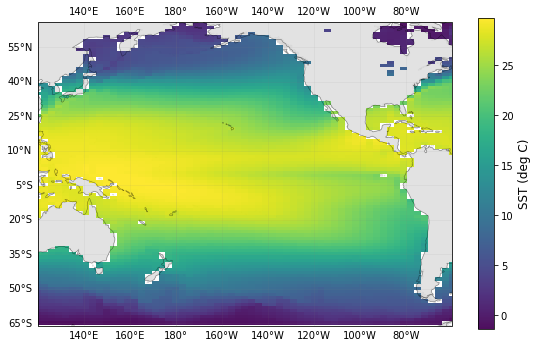

In [66]:
# load data
ds = xr.open_dataset("sst_1979_2020_pacific_coarse.nc")
print(ds)

# extract the SST data and convert it from Kelvin to Celsius
sst = ds.sst.to_masked_array()
sst = sst - 273.15

# sanity check: plot the average (over time) sst for each location on map
fig = plot_on_map(ds.lon, ds.lat, sst.mean(axis=0).T, cmap="viridis",
                  LON0=180)

In [67]:
# estimate the covariance matrix
sst_1d = sst.reshape(sst.shape[0], sst.shape[1] * sst.shape[2])
sst_1d_data = ma.compress_cols(sst_1d)
print(sst_1d_data.shape)
cov_sst = np.cov(sst_1d_data.T)
print(cov_sst.shape)

(504, 4600)
(4600, 4600)


In [68]:
# compute the eigenvalues and eigenvectors of the covariance matrix
l, ev = np.linalg.eigh(cov_sst)
l, ev = l[::-1], ev[::-1]
print("done")

done


Text(0.5, 0, 'Eigenvalue number')

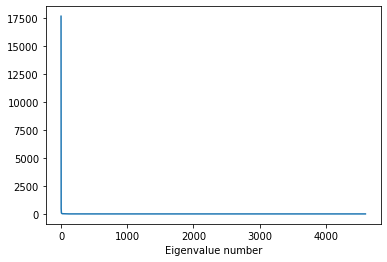

In [69]:
# plot the eigenvalues and check how they are
pl.plot(l)
pl.xlabel("Eigenvalue number")

(0.0, 50.0)

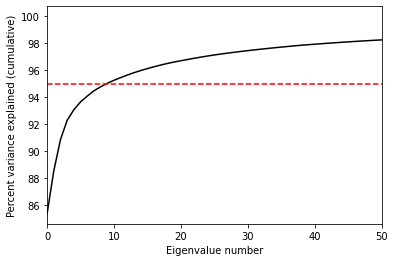

In [70]:
# compute the cumulative variance explained but the different eigenvectors
l_ = l / l.sum()
cum_var_exp = np.cumsum(l_ * 100)
pl.plot(cum_var_exp, c="k")
pl.xlabel("Eigenvalue number")
pl.ylabel("Percent variance explained (cumulative)")
pl.axhline(95., ls="--", color="r")
pl.xlim(0, 50)

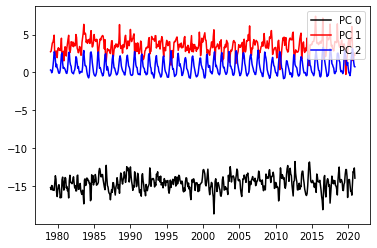

In [71]:
# visualise how the top pincipal components look like

pc_0 = np.matmul(sst_1d_data, ev[:, 0])
pc_0 = pc_0 / pc_0.std()

pc_1 = np.matmul(sst_1d_data, ev[:, 1])
pc_1 = pc_1 / pc_1.std()

pc_2 = np.matmul(sst_1d_data, ev[:, 2])
pc_2 = pc_2 / pc_2.std()

pl.plot(ds.time, pc_0, ls="-", c="k", label="PC 0")
pl.plot(ds.time, pc_1, ls="-", c="r", label="PC 1")
pl.plot(ds.time, pc_2, ls="-", c="b", label="PC 2")
pl.legend(loc="upper right")




(504,)
(504, 132, 120)
(504, 4600)


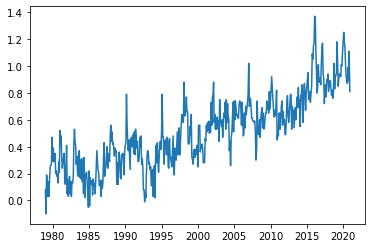

In [135]:
## linear regression model for the Oceanic Nino Index (ONI)

# load oni data
df_oni = pd.read_csv("gmst.csv", index_col=0).squeeze()
print(df.shape)
print(sst.shape)
print(sst_1d_data.shape)
pl.plot(ds.time, df_oni)

In [136]:
# use scikit-learn to construct a linear regression model
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(sst_1d_data, df_oni)
coeffs = reg.coef_
print(coeffs.shape)

# calculate the residual sum of squares
res = df_oni - reg.predict(sst_1d_data)
rss = (np.square(res)).sum()
print(rss)

(4600,)
2.2980903740971563e-07


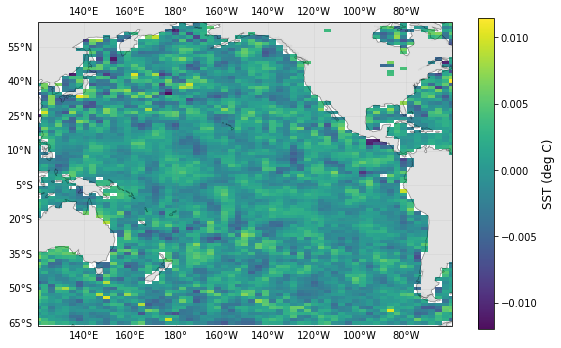

In [137]:
# plot the coefficients on the map
coeffs_map_1d = np.zeros(sst_1d.shape[1])
idx = sst_1d.mask.sum(axis=0) == 0
coeffs_map_1d[idx] = coeffs
coeffs_map_1d_ma = ma.array(coeffs_map_1d, mask=(~idx))
coeffs_map_2d_ma = coeffs_map_1d_ma.copy().reshape(ds.lat.size, ds.lon.size)

fig = plot_on_map(ds.lon, ds.lat, coeffs_map_2d_ma.T, cmap="viridis",
                  LON0=180)

(array([   2.,   21.,  104.,  497., 1548., 1661.,  624.,  125.,   15.,
           3.]),
 array([-1.5419875e-02, -1.2336188e-02, -9.2525007e-03, -6.1688139e-03,
        -3.0851269e-03, -1.4398247e-06,  3.0822472e-03,  6.1659343e-03,
         9.2496211e-03,  1.2333308e-02,  1.5416996e-02], dtype=float32),
 <BarContainer object of 10 artists>)

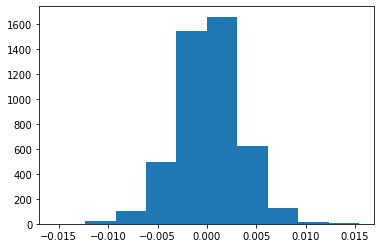

In [85]:
pl.hist(coeffs)

In [88]:
reg.score(sst_1d_data, df_oni)

0.9999999994337163

In [94]:
# use scikit-learn to do ridge regression
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=10)
ridge_reg.fit(sst_1d_data, df_oni)
ridge_coeffs = ridge_reg.coef_
print(coeffs.shape)

(4600,)


(array([   2.,   21.,  106.,  517., 1586., 1615.,  612.,  121.,   16.,
           4.]),
 array([-1.38936788e-02, -1.10983988e-02, -8.30311794e-03, -5.50783798e-03,
        -2.71255756e-03,  8.27228650e-05,  2.87800329e-03,  5.67328371e-03,
         8.46856367e-03,  1.12638446e-02,  1.40591245e-02], dtype=float32),
 <BarContainer object of 10 artists>)

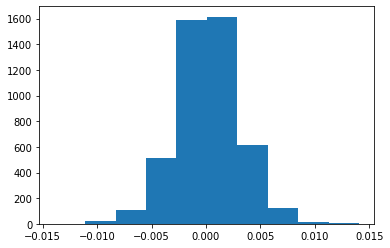

In [95]:
pl.hist(ridge_coeffs)

In [139]:
# plot error over different size of data set
# X := sst_1d_data in our case
# Y := df_oni
# X has 504 rows (time dimension) and 4600 columns (sampling locations)
# 1. choose different subsets of columns from X of different sizes
#    e.g., choose 100 cols, then 200 cols, 300 cols, ... so on  ...
# 2. repeat the regression in each case and get the residual
# 3. plot the residual over sample (i.e. data set) size

def linreg_rss(X, y):
    """
    Fits a linear regression model for y using X and returns residual sum of squares
    """
    reg = LinearRegression().fit(X, y)
    res = y - reg.predict(X)
    return (np.square(res)).sum()

idx = np.arange(1, 21)
rss = np.zeros(len(idx))
for i in idx:
    X = sst_1d_data[:, :(i*100)]
    y = df_oni
    rss[i-1] = linreg_rss(X, y)
print("done")

done


Text(0, 0.5, 'Residual sum of squares')

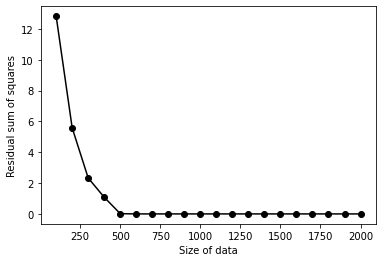

In [140]:
# plot the results
    
pl.plot(100*idx, rss, "ko-")
pl.xlabel("Size of data")
pl.ylabel("Residual sum of squares")
